In [6]:
from moviepy import VideoFileClip
import os

In [7]:
import sys
print(sys.executable)

/home/adi_6200_/mmr/.venv/bin/python


In [8]:
!uv pip list | grep -i moviepy

Using Python 3.12.3 environment at: /home/adi_6200_/mmr/.venv
moviepy                  2.2.1


In [4]:
def extract_audio(video_path: str, output_dir: str = "../data/raw/", output_ext='.wav'):
    """
    Extracts audio from the video and saves it as a WAV file. 
    """
    # create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    
    # generate the file name
    filename = os.path.basename(video_path).split('.')[0]
    output_path = os.path.join(output_dir, f'{filename}{output_ext}')
    
    if os.path.exists(output_path):
        print(f"Audio already exists at : {output_path}")
        return output_path
    
    try:
        video_clip = VideoFileClip(video_path)
        
        if video_clip.audio is None:
            print("Error: This video has no sound")
            return None
        
        video_clip.audio.write_audiofile(output_path, logger='bar')
        video_clip.close()
        return output_path
    except Exception as e:
        print(f"Error: {e}")
        return None

In [7]:
path = extract_audio(video_path="../data/raw/Interview_1.mp4")

MoviePy - Writing audio in ../data/raw/Interview_1.wav


MoviePy - Done.


## Feature Engineering for Audio Data

In [6]:
import librosa
import numpy as np
import pandas as pd
import os

In [8]:
y, sr = librosa.load("../data/raw/Interview_1.wav", sr=None)

In [ ]:
type(y)

numpy.ndarray

In [ ]:
y.shape

(15259922,)

In [11]:
sr

44100

In [14]:
y.shape[0]/(sr*60) # this should give the duration of the visdeo

5.767166288737718

In [15]:
def analyze_audio_layers(audio_path: str, segment_length: float=0.5) -> pd.DataFrame:
    """
    Input: 
        audio_path: path to the audio file
        segment_length: time window in secs (same as video dataframe)
    Output:
        au_data: dataframe with TS features for analysis (Ready to go to the data analysis pipeline)
    """
    # check is the audio file exists
    if not os.path.exists(audio_path):
        print(f"Error: {audio_path} does not exit")
        return None
    
    # loading audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # total duration
    total_duration = librosa.get_duration(y=y, sr=sr)
    
    au_data = []
    
    # iterating through the audio chunks
    for t in np.arange(0, total_duration, segment_length):
        
        # calculating the starting and ending indexes for this chunk
        start_sample = int(t * sr)
        end_sample = int((t + segment_length)*sr)
        
        # getting the chunk for this iteration
        chunk = y[start_sample:end_sample]
        
        # check if the file ended
        if len(chunk) == 0: break
        
        # FEATURE - 1: AMPLITUDE (Confidence/Volume)
        rms = np.mean(librosa.feature.rms(y=chunk))
        
        # FEATURE - 2: SILENCE DETECTION
        # Threshold: 0.005 is a standard "noise floor" for webcams
        is_silent = rms < 0.005
        
        # FEATURE 3 & 4: PITCH TRACKING (Monotone vs Expressive)
        avg_pitch = 0
        pitch_var = 0
        
        # if not silent
        if not is_silent:
            f0, voiced_flag, _ = librosa.pyin(
                chunk,
                fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C5'),
                sr=sr,
                frame_length=2048
            )
            
            # filtering out the NaNs (moments of unvoiced sound)
            valid_pitch = f0[~np.isnan(f0)]
            
            if len(valid_pitch) > 0:
                avg_pitch = np.mean(valid_pitch)
                # I think this is super cool this pitch var effectively measures you expressiveness
                pitch_var = np.std(valid_pitch) 
                
        # creating the row
        au_data.append({
            "Time": round(t, 2),
            "audio_rms(volumn)": round(rms, 4),
            "audio_pitch_avg": round(avg_pitch, 2),
            "audio_pitch_var(expressiveness)": round(pitch_var, 2),
            "is_silent": is_silent
        })
        
    # converting into a dataframe
    au_data = pd.DataFrame(au_data)
    au_data = au_data.sort_values('Time').reset_index(drop=True)
    
    return au_data
                  

In [16]:
df = analyze_audio_layers(audio_path="../data/raw/Interview_1.wav")

In [34]:
df.head(10)

,Time,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent
0,0.0,0.0000,0.00,0.00,True
1,0.5,0.0000,0.00,0.00,True
2,1.0,0.0000,0.00,0.00,True
3,1.5,0.0020,0.00,0.00,True
4,2.0,0.0141,150.88,3.73,False
5,2.5,0.0165,147.55,5.10,False
6,3.0,0.0145,149.31,3.56,False
7,3.5,0.0115,144.41,6.63,False
8,4.0,0.0141,141.26,1.33,False
9,4.5,0.0000,0.00,0.00,True


In [19]:
df.tail()

,Time,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent
688,344.0,0.0026,0.0,0.0,True
689,344.5,0.0000,0.0,0.0,True
690,345.0,0.0000,0.0,0.0,True
691,345.5,0.0000,0.0,0.0,True
692,346.0,0.0000,0.0,0.0,True


In [29]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print("Added project root to the system path")


Added project root to the system path


In [24]:
os.getcwd()

'/home/adi_6200_/mmr/notebooks'

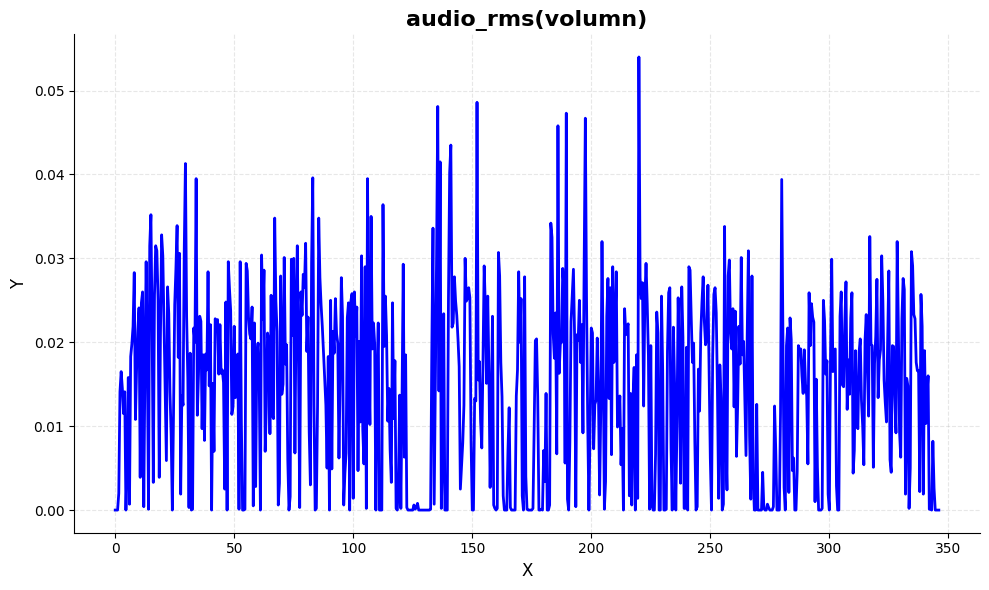

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'audio_rms(volumn)'}, xlabel='X', ylabel='Y'>)

In [35]:
from src.utils.plot_graphs import plot_beautiful

plot_beautiful(x=df['Time'], y=df['audio_rms(volumn)'], title="audio_rms(volumn)")

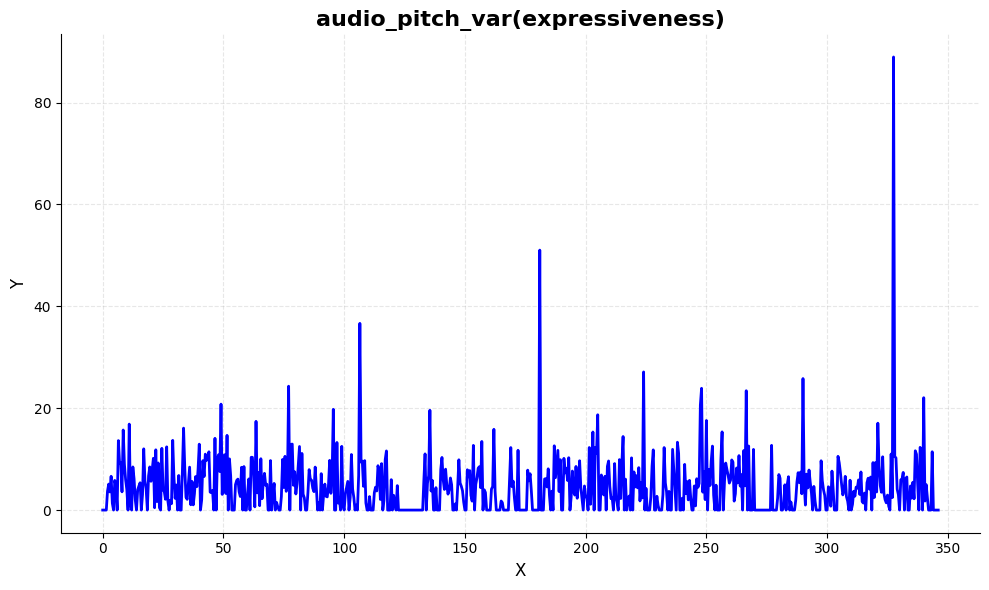

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'audio_pitch_var(expressiveness)'}, xlabel='X', ylabel='Y'>)

In [36]:
plot_beautiful(x=df['Time'], y=df['audio_pitch_var(expressiveness)'], title="audio_pitch_var(expressiveness)")

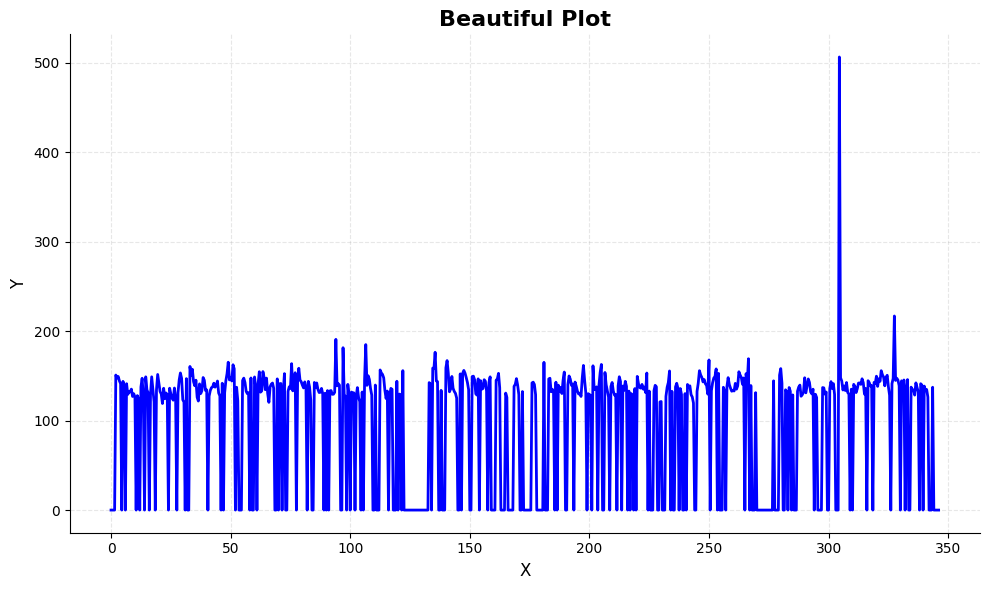

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Beautiful Plot'}, xlabel='X', ylabel='Y'>)

In [32]:
plot_beautiful(x=df['Time'], y=df['audio_pitch_avg'])

## Trying to Build the 3rd layer

In [1]:
import whisper

In [2]:
# loading model
model = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:53<00:00, 2.72MiB/s]


In [ ]:
# audio = whisper.load_audio(file="../data/raw/Interview_1.wav")
# trim_audio = whisper.pad_or_trim(audio)

In [ ]:
# mel = whisper.log_mel_spectrogram(trim_audio, n_mels=model.dims.n_mels).to(model.device)

In [ ]:
# # detecting the language
# _, probs = model.detect_language(mel)
# print(f"Detected language: {max(probs, key=probs.get)}")

In [ ]:
# # decoding the audio
# options = whisper.DecodingOptions()
# result = whisper.decode(model, mel=mel, options=options)
# print(result.text)

Yeah, man. So you asked about like if I have like if I have a document, for example PDFs and if I have PDF and PDF of a like company and I have to build the RAC system around it. So the PDF could be very messy. It could have like messy, messy data. It could have pictures


In [13]:
result = model.transcribe(audio="../data/raw/Interview_1.wav")
print(result["text"])

/home/adi_6200_/mmr/.venv/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Yeah, man. So you asked about like if I have like if I have a document, for example PDFs and if I have PDF and PDF of a like company and I have to build the RAC system around it. So the PDF could be very messy. It could have like messy metadata. It could have pictures and all. So we're asking me to build a RAC system right. So first of all we need like a proper PDF parser which could like I'll try to pre-process that data. So the PDF once I get the PDF I'll try to pre-process that PDF into I'll try to pre-process it into some data pipelines. I'll try to build some sort of data pipelines around it which extract and converts these PDFs into some structured data poems. For example, I'll try to convert a PDF and extract all the text part out of it. All the images out of it. All the tables out of it. And then I'll try to once I got this structured data, I'll then combine those. I'll then combine those to build some sort of embeddings. I'll try to use some embedding models and we'll try to 

## Using Another version of whisper

In [1]:
import whisper_timestamped as wp

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
audio = wp.load_audio(file="../data/raw/Interview_1.wav")
model = wp.load_model('small', device='cpu')

In [3]:
result = wp.transcribe_timestamped(
    model=model,
    audio=audio,
    language=None,
    detect_disfluencies=True
)

Detected language: English


 99%|█████████▉| 34416/34603 [04:04<00:01, 140.77frames/s]


In [9]:
result

{'text': " Yeah man so you asked about like if I have document for example PDFs and if I have PDF and PDF of a company and I have to build a rack system around it so the PDF could be very messy it could have like messy data it could have pictures and all so you are asking me to build a rack system right so first of all we need like a proper PDF parser which could like I'll try to pre-process that data so the PDF once I get the PDF I'll try to pre-process that PDF into I'll try to pre-process it into some data pipelines so I'll try to build some sort of data pipelines around it which extract and convert these PDFs into some structured data forms for example I'll try to convert a PDF and extract all the text part out of it all the images out of it all the tables out of it and then I'll try to once I got this structured data I'll then combine those I'll then combine those to build some sort of you know embeddings I'll try to use some embedding models and we'll try to embed these embedding

In [ ]:
tr_df = pd.DataFrame(result["segments"])

In [12]:
tr_df.head()

,id,seek,start,end,text,tokens,temperature,avg_logprob,compression_ratio,no_speech_prob,confidence,words
0,0,0,1.82,13.24,Yeah man so you asked about like if I have do...,"[50364, 865, 587, 370, 291, 2351, 466, 411, 49...",0.0,-0.316882,1.641509,0.652354,0.744,"[{'text': 'Yeah', 'start': 1.82, 'end': 1.96, ..."
1,1,0,13.36,20.19,and PDF of a company and I have to build a ra...,"[51046, 293, 17752, 295, 257, 2237, 293, 286, ...",0.0,-0.316882,1.641509,0.652354,0.797,"[{'text': '[*]', 'start': 13.36, 'end': 13.5, ..."
2,2,0,20.19,29.28,very messy it could have like messy data it c...,"[51380, 588, 16191, 309, 727, 362, 411, 16191,...",0.0,-0.316882,1.641509,0.652354,0.849,"[{'text': '[*]', 'start': 20.19, 'end': 20.4, ..."
3,3,2932,29.32,37.14,me to build a rack system right so first of a...,"[50364, 385, 281, 1322, 257, 14788, 1185, 558,...",0.0,-0.190130,1.773333,0.113389,0.912,"[{'text': 'me', 'start': 29.32, 'end': 29.5, '..."
4,4,2932,37.16,44.48,could like I'll try to pre-process that data ...,"[50754, 727, 411, 286, 603, 853, 281, 659, 12,...",0.0,-0.190130,1.773333,0.113389,0.906,"[{'text': 'could', 'start': 37.16, 'end': 37.3..."


In [13]:
tr_df["words"].iloc[0]

[{'text': 'Yeah', 'start': 1.82, 'end': 1.96, 'confidence': 0.271},
 {'text': 'man', 'start': 1.96, 'end': 2.16, 'confidence': 0.607},
 {'text': 'so', 'start': 2.16, 'end': 2.36, 'confidence': 0.573},
 {'text': 'you', 'start': 2.36, 'end': 2.58, 'confidence': 0.955},
 {'text': 'asked', 'start': 2.58, 'end': 2.92, 'confidence': 0.927},
 {'text': '[*]', 'start': 2.92, 'end': 3.74, 'confidence': 0.0},
 {'text': 'about', 'start': 3.74, 'end': 3.98, 'confidence': 0.889},
 {'text': '[*]', 'start': 3.98, 'end': 5.28, 'confidence': 0.0},
 {'text': 'like', 'start': 5.28, 'end': 5.58, 'confidence': 0.689},
 {'text': '[*]', 'start': 5.58, 'end': 6.58, 'confidence': 0.0},
 {'text': 'if', 'start': 6.58, 'end': 6.74, 'confidence': 0.812},
 {'text': 'I', 'start': 6.74, 'end': 6.9, 'confidence': 0.868},
 {'text': '[*]', 'start': 6.9, 'end': 7.82, 'confidence': 0.0},
 {'text': 'have', 'start': 7.82, 'end': 8.08, 'confidence': 0.801},
 {'text': '[*]', 'start': 8.08, 'end': 8.9, 'confidence': 0.0},
 {'te